## описание таблиц

# Описание данных train.csv

- `county` - Уникальный идентификатор округа.
- `is_business` - Логический индикатор, определяющий, является ли потребитель бизнесом.
- `product_type` - Код типа продукта с соответствием: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- `target` - Количество потребления или производства для соответствующего сегмента за час. Сегменты определяются по округу, `is_business` и `product_type`.
- `is_consumption` - Логический индикатор, определяющий, является ли цель строки потреблением или производством.
- `datetime` - Время по Эстонии в EET (UTC+2) / EEST (UTC+3). Описывает начало 1-часового периода, на который дана цель.
- `data_block_id` - Все строки с одним и тем же `data_block_id` будут доступны в одно и то же время прогноза. Это зависит от доступности информации на момент составления прогнозов в 11 утра каждое утро.
- `row_id` - Уникальный идентификатор строки.
- `prediction_unit_id` - Уникальный идентификатор комбинации округа, `is_business` и `product_type`. В тестовом наборе могут появляться или исчезать новые единицы прогнозирования.

# Файл gas_prices.csv

- `origin_date` - Дата, когда стали доступны цены "day-ahead".
- `forecast_date` - Дата, когда прогнозируемые цены должны быть актуальны.
- `[lowest/highest]_price_per_mwh` - Наименьшая/наибольшая цена природного газа на рынке дня вперед в евро за мегаватт-час.

# Файл client.csv

- `product_type`
- `county` - Уникальный идентификатор округа.
- `eic_count` - Агрегированное количество точек потребления (EIC - European Identifier Code).
- `installed_capacity` - Установленная мощность солнечных панелей в киловаттах.
- `is_business` - Логический индикатор, определяющий, является ли потребитель бизнесом.
- `date`
- `data_block_id`

# Файл electricity_prices.csv

- `origin_date`
- `forecast_date` - Отмечает начало 1-часового периода, когда действует цена.
- `euros_per_mwh` - Цена электроэнергии на рынках дня вперед в евро за мегаватт-час.

# Файл forecast_weather.csv

- `[latitude/longitude]` - Координаты места прогноза погоды.
- `origin_datetime` - Временная метка, когда был сгенерирован прогноз.
- `hours_ahead` - Количество часов между генерацией прогноза и погодой прогноза. Каждый прогноз охватывает 48 часов.
- `temperature` - Температура воздуха на высоте 2 метра над землей в градусах Цельсия.
- `dewpoint` - Точка росы на высоте 2 метра над землей в градусах Цельсия.
- `cloudcover_[low/mid/high/total]` - Процент покрытия неба облаками на разных высотах.
- `10_metre_[u/v]_wind_component` - [Восточная/северная] составляющая скорости ветра на высоте 10 метров над поверхностью.
- `data_block_id`
- `forecast_datetime` - Временная метка прогнозируемой погоды.
- `direct_solar_radiation` - Прямая солнечная радиация на поверхность за час.
- `surface_solar_radiation_downwards` - Солнечная радиация (прямая и рассеянная) на горизонтальной поверхности за час.
- `snowfall` - Снегопад за час в метрах водного эквивалента.
- `total_precipitation` - Общее количество осадков за час в метрах.

# Файл historical_weather.csv

- `datetime` - Начало 1-часового периода, за который измеряются данные о погоде.
- `temperature` - Измеренная температура воздуха.
- `dewpoint` - Измеренная точка росы.
- `rain` - Осадки от крупномасштабных систем.
- `snowfall` - Снегопад за час в сантиметрах.
- `surface_pressure` - Давление воздуха на поверхности.
- `cloudcover_[low/mid/high/total]` - Облачность на разных высотах.
- `windspeed_10m` - Скорость ветра на высоте 10 метров.
- `winddirection_10m` - Направление ветра на высоте 10 метров.
- `shortwave_radiation` - Глобальное горизонтальное излучение.
- `direct_solar_radiation`
- `diffuse_radiation` - Рассеянное солнечное излучение.
- `[latitude/longitude]` - Координаты метеостанции.
- `data_block_id`



In [1]:
import os  # Для взаимодействия с операционной системой
import gc  # Для управления сборкой мусора
import pickle  # Для сериализации объектов

import numpy as np  # Для численных операций
import pandas as pd  # Для работы с таблицами данных
import polars as pl  # Для работы с данными (альтернатива Pandas)

from sklearn.model_selection import cross_val_score, cross_validate  # Для кросс-валидации
from sklearn.metrics import mean_absolute_error  # Для вычисления средней абсолютной ошибки
from sklearn.compose import TransformedTargetRegressor  # Для преобразования целевой переменной
from sklearn.ensemble import VotingRegressor  # Для ансамблевого регрессора

import lightgbm as lgb  # Библиотека для градиентного бустинга
import catboost as cb  # Библиотека для градиентного бустинга

import optuna  # Библиотека для оптимизации гиперпараметров

import matplotlib.pyplot as plt  # Для визуализации данных




сохраенении загрузка моделей

In [2]:
load_path = None
save_path = None

In [3]:
# load_path=('/kaggle/input/model-ergo')
load_path=('/kaggle/input/model-ergo/log')
save_path=('/kaggle/working/models')


In [4]:
class MonthlyKFold:
    def __init__(self, n_splits=3):
        self.n_splits = n_splits
        
    def split(self, X, y, groups=None):
        dates = 12 * X["year"] + X["month"]
        timesteps = sorted(dates.unique().tolist())
        X = X.reset_index()
        
        for t in timesteps[-self.n_splits:]:
            idx_train = X[dates.values < t].index
            idx_test = X[dates.values == t].index
            
            yield idx_train, idx_test
            
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [5]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )
    
    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )
    
    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns(
            (pl.col("date") + pl.duration(days=1)).cast(pl.Date)
        )
    )
    
    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(
            pl.col("datetime") + pl.duration(days=1)
        )
    )
    
    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )
    
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col('datetime').dt.replace_time_zone(None).cast(pl.Datetime("us")),
#             pl.col('datetime').dt.convert_time_zone("Europe/Bucharest").dt.replace_time_zone(None).cast(pl.Datetime("us")),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col("datetime") + pl.duration(hours=37)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_historical_date = (
        df_historical
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_historical_local = (
        df_historical
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    # Объединение всех обработанных данных с основным датафреймом df_data
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        
        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_historical_date, on="datetime", how="left", suffix="_hd")
        .join(df_historical_local, on=["county", "datetime"], how="left", suffix="_hl")
        
        .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(days=7)), on="datetime", how="left", suffix="_fdw")
        .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_flw")
        .join(df_historical_date.with_columns(pl.col("datetime") + pl.duration(days=7)), on="datetime", how="left", suffix="_hdw")
        .join(df_historical_local.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_hlw")
        
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=2)).rename({"target": "target_1"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=3)).rename({"target": "target_2"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=4)).rename({"target": "target_3"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=5)).rename({"target": "target_4"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=6)).rename({"target": "target_5"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=7)).rename({"target": "target_6"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=14)).rename({"target": "target_7"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        # Создание категориальных признаков и тригонометрических функций времени
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"), # Добавление номера дня в году
            pl.col("datetime").dt.hour().alias("hour"),# Добавление часа
            pl.col("datetime").dt.day().alias("day"),# Добавление дня
            pl.col("datetime").dt.weekday().alias("weekday"),# Добавление дня недели
            pl.col("datetime").dt.month().alias("month"),# Добавление месяца
            pl.col("datetime").dt.year().alias("year"),# Добавление года
        )
        # Приведение типов данных
        .with_columns(
            pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("category_1"),
        )
        
        .with_columns(
            (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"), # Тригонометрические функции для дня в году
            (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )
        
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
         # Удаление ненужных колонок
        .drop("date", "datetime", "hour", "dayofyear")
    )
    
    return df_data

In [6]:
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption", "category_1"]
    
    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()    
    
    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")
    
    df["target_mean"] = df[[f"target_{i}" for i in range(1, 7)]].mean(1)
    df["target_std"] = df[[f"target_{i}" for i in range(1, 7)]].std(1)
    df["target_ratio"] = df["target_6"] / (df["target_7"] + 1e-3)
    
    return df

In [7]:
# для оптуны
def lgb_objective(trial):
    params = {
        'n_iter'           : 1000,
        'verbose'          : -1,
        'random_state'     : 42,
        'objective'        : 'l2',
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'lambda_l1'        : trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2'        : trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 4, 256),
        'max_depth'        : trial.suggest_int('max_depth', 5, 10),
        'max_bin'          : trial.suggest_int('max_bin', 32, 1024),
    }
    
    model  = lgb.LGBMRegressor(**params)
    X, y   = df_train.drop(columns=["target"]), df_train["target"]
    cv     = MonthlyKFold(1)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    return -1 * np.mean(scores)

# Исследование

In [8]:
# Загрузка данных об энергопотреблении
train = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv")

# Создание сводной таблицы с средними значениями целевой переменной (target)
# для каждой комбинации даты, округа, типа продукта, бизнеса и потребления
pivot_train = train.pivot_table(
    index='datetime',
    columns=['county', 'product_type', 'is_business', 'is_consumption'],
    values='target',
    aggfunc='mean'
)

# Переименование колонок для удобства доступа и интерпретации
pivot_train.columns = ['county{}_productType{}_isBusiness{}_isConsumption{}'.format(*col) for col in pivot_train.columns.values]
pivot_train.index = pd.to_datetime(pivot_train.index)

pivot_train

,county0_productType0_isBusiness1_isConsumption0,county0_productType0_isBusiness1_isConsumption1,county0_productType1_isBusiness0_isConsumption0,county0_productType1_isBusiness0_isConsumption1,county0_productType1_isBusiness1_isConsumption0,county0_productType1_isBusiness1_isConsumption1,county0_productType2_isBusiness0_isConsumption0,county0_productType2_isBusiness0_isConsumption1,county0_productType2_isBusiness1_isConsumption0,county0_productType2_isBusiness1_isConsumption1,...,county15_productType0_isBusiness1_isConsumption0,county15_productType0_isBusiness1_isConsumption1,county15_productType1_isBusiness0_isConsumption0,county15_productType1_isBusiness0_isConsumption1,county15_productType1_isBusiness1_isConsumption0,county15_productType1_isBusiness1_isConsumption1,county15_productType3_isBusiness0_isConsumption0,county15_productType3_isBusiness0_isConsumption1,county15_productType3_isBusiness1_isConsumption0,county15_productType3_isBusiness1_isConsumption1
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,0.000,59.000,0.713,96.590,0.000,501.760,0.000,17.314,NaN,NaN,...,NaN,NaN,0.000,5.524,0.100,17.703,0.000,59.366,0.000,289.159
2021-09-01 01:00:00,0.000,61.600,1.132,77.691,0.000,486.297,0.000,15.872,NaN,NaN,...,NaN,NaN,0.000,4.632,0.100,20.416,0.000,56.357,0.000,280.657
2021-09-01 02:00:00,0.000,63.100,0.490,91.594,0.000,458.562,0.000,16.510,NaN,NaN,...,NaN,NaN,0.000,5.461,0.100,27.440,0.000,51.038,0.000,295.537
2021-09-01 03:00:00,0.000,64.000,0.496,87.955,0.000,511.794,0.000,14.271,NaN,NaN,...,NaN,NaN,0.000,4.617,0.000,19.050,0.000,48.482,0.000,287.724
2021-09-01 04:00:00,0.000,60.500,0.149,88.184,0.000,520.318,0.000,18.225,NaN,NaN,...,NaN,NaN,0.000,4.578,0.100,21.228,0.000,57.115,0.000,286.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 19:00:00,45.516,592.897,439.610,300.096,126.947,761.060,3.346,2.978,5.709,11.249,...,20.147,530.777,26.074,27.369,59.005,13.353,124.516,65.457,111.403,171.252
2023-05-31 20:00:00,12.259,586.746,120.856,443.340,27.563,827.122,0.792,2.730,1.546,14.582,...,8.649,537.154,19.584,35.140,25.563,13.756,43.101,85.693,43.751,232.759
2023-05-31 21:00:00,1.984,544.978,22.428,569.301,5.091,808.137,0.136,3.997,0.304,19.392,...,1.260,323.350,1.804,52.427,2.840,24.250,6.982,124.146,7.030,265.328


## 2023 год 

<Axes: xlabel='datetime'>

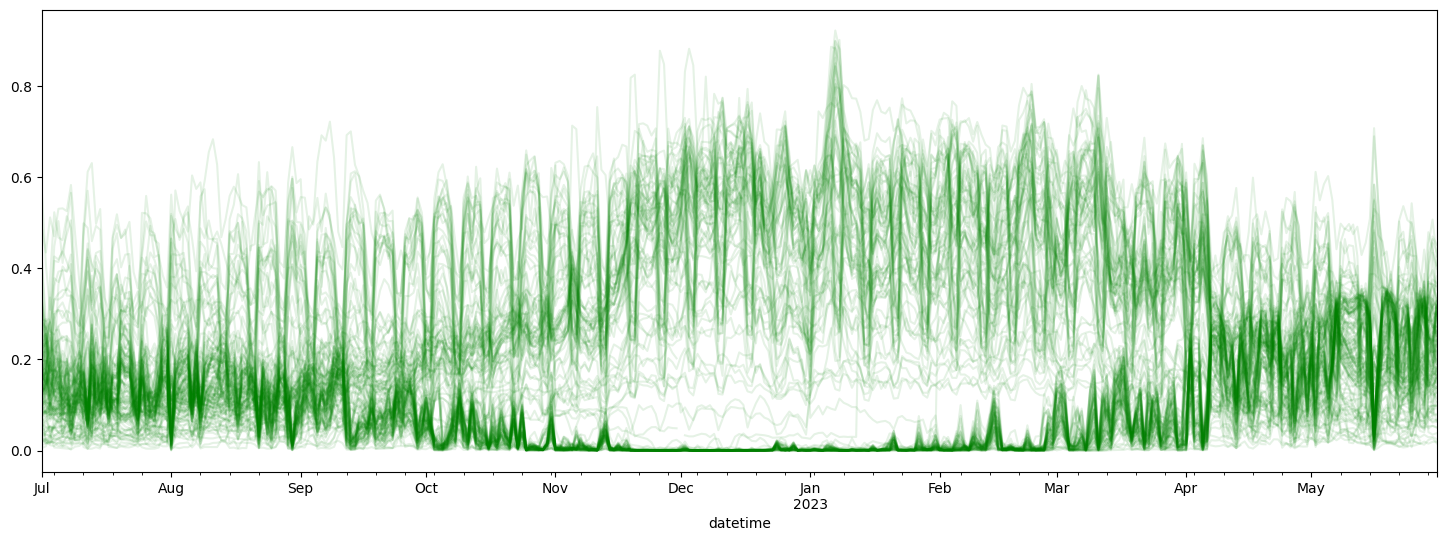

In [9]:
# Копирование сводной таблицы для визуализации
df_plot = pivot_train.copy()

# Нормализация данных для визуализации
df_plot = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

# Ресемплирование данных по дням и вычисление средних значений
df_plot_resampled_D = df_plot.resample('D').mean()

# Визуализация нормализованных данных с прозрачностью (alpha=0.1)
df_plot_resampled_D.loc['2022-7':].plot(alpha=0.1, color='green', figsize=(18, 6), legend=False)


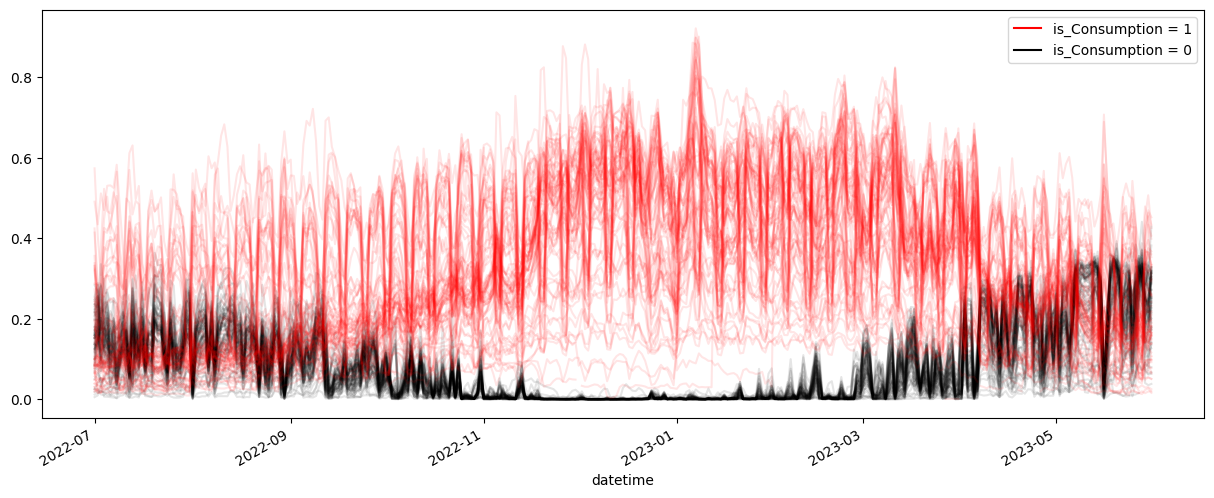

In [10]:
# Выбор колонок, соответствующих различным категориям потребления
columns_consumption_0 = df_plot_resampled_D.columns[df_plot_resampled_D.columns.str.contains('isConsumption0')]
columns_consumption_1 = df_plot_resampled_D.columns[df_plot_resampled_D.columns.str.contains('isConsumption1')]

# Создание фигуры для визуализации
plt.figure(figsize=(15, 6))

# Создание пустых линий для легенды
plt.plot([], color='red', label='is_Consumption = 1')  # Изменено на красный цвет
plt.plot([], color='black', label='is_Consumption = 0')   # Изменено на черный цвет

# Отображение легенды
plt.legend()

# Визуализация данных для 'is_Consumption = 0' черным цветом
for column in columns_consumption_0:
    df_plot_resampled_D.loc['2022-7':, column].plot(alpha=0.1, color='black', legend=False)  # Изменено на черный

# Визуализация данных для 'is_Consumption = 1' красным цветом
for column in columns_consumption_1:
    df_plot_resampled_D.loc['2022-7':, column].plot(alpha=0.1, color='red', legend=False)  # Изменено на красный

# Отображение графика
plt.show()




### Global Variables

In [11]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']



### Data I/O

In [12]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
#df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "/kaggle/input/locations/county_lon_lats.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema

## NEW LOGрифм

In [13]:
# # Список столбцов для логарифмирования
# to_log = [
#     'eic_count', 'installed_capacity', 'euros_per_mwh', 
#     'direct_solar_radiation', 'surface_solar_radiation_downwards', 
#     'snowfall', 'total_precipitation', 'direct_solar_radiation_fl', 
#     'surface_solar_radiation_downwards_fl', 'snowfall_fl', 
#     'total_precipitation_fl', 'surface_pressure', 'direct_solar_radiation_hd', 
#     'diffuse_radiation', 'snowfall_hl', 'surface_pressure_hl', 
#     'snowfall_fdw', 'total_precipitation_fdw', 'direct_solar_radiation_flw', 
#     'surface_solar_radiation_downwards_flw', 'snowfall_flw', 
#     'total_precipitation_flw', 'surface_pressure_hdw', 'snowfall_hdw', 
#     'direct_solar_radiation_hlw', 'diffuse_radiation_hlw', 
#     'snowfall_hlw', 'target', 'target_mean', 
#     'target_std', 'target_ratio'
# ]
# for i in to_log:
#     # Применение логарифмического преобразования к каждому столбцу из списка
#     # np.where используется для обработки нулевых значений: если значение в столбце равно 0, результат будет 0
#     # В противном случае применяется натуральный логарифм
#     train[f"log_{i}"] = np.where((train[i]) != 0, np.log(train[i]), 0)

### Feature Engineering

In [14]:
X, y = df_data.drop("target"), df_data.select("target")

X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)

df_train = to_pandas(X, y)

In [15]:
df_train.head() 

,county,is_business,product_type,is_consumption,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,euros_per_mwh,hours_ahead,...,year,category_1,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),target,target_mean,target_std,target_ratio
row_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,2021,0_0_1_0,-0.866025,-0.5,0.0,1.0,0.713,NaN,NaN,NaN
1,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2021,0_0_1_1,-0.866025,-0.5,0.0,1.0,96.590,NaN,NaN,NaN
2,0,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,...,2021,0_0_2_0,-0.866025,-0.5,0.0,1.0,0.000,NaN,NaN,NaN
3,0,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2021,0_0_2_1,-0.866025,-0.5,0.0,1.0,17.314,NaN,NaN,NaN
4,0,0,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,2021,0_0_3_0,-0.866025,-0.5,0.0,1.0,2.904,NaN,NaN,NaN


In [16]:
df_train = df_train[df_train["target"].notnull() & df_train["year"].gt(2021)]

In [17]:
df_train.head() 

,county,is_business,product_type,is_consumption,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,euros_per_mwh,hours_ahead,...,year,category_1,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),target,target_mean,target_std,target_ratio
row_id,,,,,,,,,,,,,,,,,,,,,
366048,0,0,1,0,80.0,94.0,148.0,1345.689941,65.760002,35.0,...,2022,0_0_1_0,0.017166,0.999853,0.0,1.0,0.000,0.279667,0.569453,7.000000
366049,0,0,1,1,80.0,94.0,148.0,1345.689941,65.760002,35.0,...,2022,0_0_1_1,0.017166,0.999853,0.0,1.0,442.226,412.962311,22.043884,1.382337
366050,0,0,2,0,80.0,94.0,16.0,153.699997,65.760002,35.0,...,2022,0_0_2_0,0.017166,0.999853,0.0,1.0,0.000,0.000000,0.000000,0.000000
366051,0,0,2,1,80.0,94.0,16.0,153.699997,65.760002,35.0,...,2022,0_0_2_1,0.017166,0.999853,0.0,1.0,44.899,43.781834,2.328470,1.557458
366052,0,0,3,0,80.0,94.0,739.0,7638.620117,65.760002,35.0,...,2022,0_0_3_0,0.017166,0.999853,0.0,1.0,0.015,0.295667,0.274237,0.869186


In [18]:
# Подсчет количества NaN значений в каждом столбце
nan_counts = df_train.isna().sum()
total_rows = len(df_train)

# Рассчитываем процент NaN значений от общего числа строк
nan_percentages = (nan_counts / total_rows) * 100

# Создаем DataFrame с информацией о NaN
nan_info = pd.DataFrame({'Количество NaN': nan_counts, 'Процент NaN': nan_percentages})

# Фильтруем только столбцы с NaN и сортируем по проценту
nan_info = nan_info[nan_info['Количество NaN'] > 0].sort_values(by='Процент NaN', ascending=False)

# Выводим топ-10 столбцов с наибольшим процентом NaN
print("Топ-10 столбцов с наибольшим процентом NaN:")
print(nan_info.head(10))


Топ-10 столбцов с наибольшим процентом NaN:
                                       Количество NaN  Процент NaN
surface_solar_radiation_downwards_flw           25022     1.514739
cloudcover_low_flw                              25022     1.514739
snowfall_flw                                    25022     1.514739
hours_ahead_flw                                 25022     1.514739
temperature_flw                                 25022     1.514739
cloudcover_high_flw                             25022     1.514739
dewpoint_flw                                    25022     1.514739
cloudcover_mid_flw                              25022     1.514739
cloudcover_total_flw                            25022     1.514739
10_metre_u_wind_component_flw                   25022     1.514739


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1651902 entries, 366048 to 2018351
Columns: 137 entries, county to target_ratio
dtypes: category(5), float32(126), float64(2), int32(1), uint32(3)
memory usage: 866.5 MB


In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Предполагаем, что df_train - это ваш DataFrame
# # df_train = pd.read_csv('your_file.csv') # Пример загрузки данных

# # Выбираем все столбцы с подходящими типами данных
# numeric_columns = df_train.select_dtypes(include=['float32', 'float64', 'int32', 'uint32']).columns

# for column in numeric_columns:
#     plt.figure(figsize=(10, 4))
#     plt.boxplot(df_train[column].dropna(), vert=False) # Горизонтальный ящик с усами
#     plt.title(f'Горизонтальный ящик с усами для {column}')
#     plt.show()
    
#     Q1 = df_train[column].quantile(0.25)
#     Q3 = df_train[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     outliers = df_train[(df_train[column] < lower_bound) | (df_train[column] > upper_bound)]
#     n_outliers = len(outliers)
#     total_values = len(df_train[column].dropna())
#     percent_outliers = (n_outliers / total_values) * 100

#     print(f'Столбец: {column}')
#     print(f'Минимум: {df_train[column].min()}')
#     print(f'Максимум: {df_train[column].max()}')
#     print(f'Среднее: {df_train[column].mean()}')
#     print(f'Стандартное отклонение: {df_train[column].std()}')
#     print(f'Количество выбросов: {n_outliers}')
#     print(f'Процент выбросов: {percent_outliers:.2f}%')
    
#     if percent_outliers > 5:
#         print('Рекомендация: Нормировать через логарифмирование.')
#     else:
#         print('Рекомендация: Нормирование не требуется.')
#     print('\n')


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

to_log = [] # Список для хранения названий столбцов, требующих логарифмирования

# Выбор столбцов с числовыми данными
numeric_columns = df_train.select_dtypes(include=['float32', 'float64', 'int32', 'uint32']).columns

# Перебор всех числовых столбцов для определения выбросов
for column in numeric_columns:
    # Определение первого и третьего квартиля
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    # Расчет межквартильного размаха
    IQR = Q3 - Q1
    # Определение границ для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Фильтрация выбросов
    outliers = df_train[(df_train[column] < lower_bound) | (df_train[column] > upper_bound)]
    # Подсчет количества выбросов
    n_outliers = len(outliers)
    # Общее количество значений в столбце без учета NaN
    total_values = len(df_train[column].dropna())
    # Расчет процентного соотношения выбросов
    percent_outliers = (n_outliers / total_values) * 100

    # Если процент выбросов превышает 5%, столбец добавляется в список to_log
    if percent_outliers > 5:
        to_log.append(column)


print('Столбцы для логарифмирования:')
print(to_log)


Столбцы для логарифмирования:
['eic_count', 'installed_capacity', 'euros_per_mwh', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation', 'direct_solar_radiation_fl', 'surface_solar_radiation_downwards_fl', 'snowfall_fl', 'total_precipitation_fl', 'rain', 'snowfall_hd', 'shortwave_radiation', 'direct_solar_radiation_hd', 'rain_hl', 'snowfall_hl', 'shortwave_radiation_hl', 'direct_solar_radiation_hl', 'surface_solar_radiation_downwards_fdw', 'snowfall_fdw', 'total_precipitation_fdw', 'direct_solar_radiation_flw', 'surface_solar_radiation_downwards_flw', 'snowfall_flw', 'total_precipitation_flw', 'rain_hdw', 'snowfall_hdw', 'shortwave_radiation_hdw', 'direct_solar_radiation_hdw', 'rain_hlw', 'snowfall_hlw', 'shortwave_radiation_hlw', 'direct_solar_radiation_hlw', 'target_1', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6', 'target_7', 'target', 'target_mean', 'target_std', 'target_ratio']


In [22]:
# Словарь для хранения информации о столбцах с отрицательными значениями и их процентах
negative_values_info = {}

for column in to_log:
    # Проверяем, есть ли в столбце отрицательные значения
    negative_count = (df_train[column] < 0).sum()
    if negative_count > 0:
        # Рассчитываем процент отрицательных значений
        total_count = df_train[column].count()
        negative_percentage = (negative_count / total_count) * 100
        negative_values_info[column] = negative_percentage

        # Заменяем отрицательные значения на 0
        df_train[column] = df_train[column].apply(lambda x: 0 if x < 0 else x)

# Выводим информацию о проценте отрицательных значений
for column, percentage in negative_values_info.items():
    print(f"Столбец: {column}, Процент отрицательных значений: {percentage:.2f}%")

print('Отрицательные значения заменены на 0')


Столбец: euros_per_mwh, Процент отрицательных значений: 0.23%
Столбец: surface_solar_radiation_downwards, Процент отрицательных значений: 1.80%
Столбец: snowfall, Процент отрицательных значений: 0.60%
Столбец: total_precipitation, Процент отрицательных значений: 0.43%
Столбец: direct_solar_radiation_fl, Процент отрицательных значений: 2.19%
Столбец: surface_solar_radiation_downwards_fl, Процент отрицательных значений: 1.99%
Столбец: snowfall_fl, Процент отрицательных значений: 1.15%
Столбец: total_precipitation_fl, Процент отрицательных значений: 1.68%
Столбец: surface_solar_radiation_downwards_fdw, Процент отрицательных значений: 1.81%
Столбец: snowfall_fdw, Процент отрицательных значений: 0.60%
Столбец: total_precipitation_fdw, Процент отрицательных значений: 0.42%
Столбец: direct_solar_radiation_flw, Процент отрицательных значений: 2.15%
Столбец: surface_solar_radiation_downwards_flw, Процент отрицательных значений: 1.99%
Столбец: snowfall_flw, Процент отрицательных значений: 1.18%


In [23]:
# Применение логарифмического преобразования к каждому столбцу из списка
# np.where используется для обработки нулевых значений: если значение в столбце равно 0, результат будет 0
# В противном случае применяется натуральный логарифм    
for i in to_log:
    # Замена NaN значений на 0
    df_train[i] = df_train[i].fillna(0)

    # Проверка и корректировка отрицательных значений
    df_train[i] = df_train[i].apply(lambda x: max(x, 0))

    # Применение безопасного логарифмического преобразования
    df_train[i] = np.log1p(df_train[i])

print('Log ok')


Log ok


In [24]:
df_train.head() 

,county,is_business,product_type,is_consumption,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,euros_per_mwh,hours_ahead,...,year,category_1,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),target,target_mean,target_std,target_ratio
row_id,,,,,,,,,,,,,,,,,,,,,
366048,0,0,1,0,80.0,94.0,5.003946,7.205405,4.201104,35.0,...,2022,0_0_1_0,0.017166,0.999853,0.0,1.0,0.000000,0.246600,0.450727,2.079442
366049,0,0,1,1,80.0,94.0,5.003946,7.205405,4.201104,35.0,...,2022,0_0_1_1,0.017166,0.999853,0.0,1.0,6.094080,6.025775,3.137400,0.868082
366050,0,0,2,0,80.0,94.0,2.833213,5.041488,4.201104,35.0,...,2022,0_0_2_0,0.017166,0.999853,0.0,1.0,0.000000,0.000000,0.000000,0.000000
366051,0,0,2,1,80.0,94.0,2.833213,5.041488,4.201104,35.0,...,2022,0_0_2_1,0.017166,0.999853,0.0,1.0,3.826443,3.801803,1.202513,0.939014
366052,0,0,3,0,80.0,94.0,6.606650,8.941103,4.201104,35.0,...,2022,0_0_3_0,0.017166,0.999853,0.0,1.0,0.014889,0.259025,0.242347,0.625503


In [25]:
# df_train.info(verbose=True)

### HyperParam Optimization

In [26]:
# study = optuna.create_study(direction='minimize', study_name='Regressor')
# study.optimize(lgb_objective, n_trials=100, show_progress_bar=True)

### Validation

In [27]:
'''result = cross_validate(
    estimator=lgb.LGBMRegressor(**best_params, random_state=42),
    X=df_train.drop(columns=["target"]), 
    y=df_train["target"],
    scoring="neg_mean_absolute_error",
    cv=MonthlyKFold(1),
)

print(f"Fit Time(s): {result['fit_time'].mean():.3f}")
print(f"Score Time(s): {result['score_time'].mean():.3f}")
print(f"Error(MAE): {-result['test_score'].mean():.3f}")'''

'result = cross_validate(\n    estimator=lgb.LGBMRegressor(**best_params, random_state=42),\n    X=df_train.drop(columns=["target"]), \n    y=df_train["target"],\n    scoring="neg_mean_absolute_error",\n    cv=MonthlyKFold(1),\n)\n\nprint(f"Fit Time(s): {result[\'fit_time\'].mean():.3f}")\nprint(f"Score Time(s): {result[\'score_time\'].mean():.3f}")\nprint(f"Error(MAE): {-result[\'test_score\'].mean():.3f}")'

### Training

In [28]:
# #LGB
p1={'n_estimators': 1000,'verbose': -1,'objective': 'l2','learning_rate': 0.06258413085998576, 'colsample_bytree': 0.6527661140701613, 'colsample_bynode': 0.8106858631408332, 'lambda_l1': 5.065645378814257, 'lambda_l2': 9.81159370218779, 'min_data_in_leaf': 192, 'max_depth': 10, 'max_bin': 1800}
p2={'n_estimators': 1000,'verbose': -1,'objective': 'l2','learning_rate': 0.0632167263149817, 'colsample_bytree': 0.6958033941948067, 'colsample_bynode': 0.6030801666196094, 'lambda_l1': 7.137580620471935, 'lambda_l2': 9.348169401713742, 'min_data_in_leaf': 74, 'max_depth': 11, 'max_bin': 530}
p3={'n_estimators': 1000,'verbose': -1,'objective': 'l2','learning_rate': 0.061236402165228264, 'colsample_bytree': 0.81427095118471, 'colsample_bynode': 0.6097376843527067, 'lambda_l1': 6.360490880385201, 'lambda_l2': 9.954136008333839, 'min_data_in_leaf': 238, 'max_depth': 13, 'max_bin': 649}
p4={'n_estimators': 1000,'verbose': -1,'objective': 'l2','learning_rate': 0.06753282378023663, 'colsample_bytree': 0.7508715107428325, 'colsample_bynode': 0.6831819500325418, 'lambda_l1': 8.679353563755722, 'lambda_l2': 6.105008696961338, 'min_data_in_leaf': 198, 'max_depth': 15, 'max_bin': 835}
p5={'n_estimators': 1000,'verbose': -1,'objective': 'l2','learning_rate': 0.05129380742257108, 'colsample_bytree': 0.5101576947777211, 'colsample_bynode': 0.8052639518604396, 'lambda_l1': 8.087311995794915, 'lambda_l2': 5.067361158677095, 'min_data_in_leaf': 222, 'max_depth': 8, 'max_bin': 97}
p6={'n_estimators': 900,'verbose': -1,'objective': 'l2','learning_rate': 0.05689066836106983,'colsample_bytree': 0.8915976762048253,'colsample_bynode': 0.5942203285139224,'lambda_l1': 3.6277555139102864,'lambda_l2': 1.6591278779517808,'min_data_in_leaf' : 186,'max_depth': 9,'max_bin': 813,}

p7={'n_estimators': 1483,'verbose': -1,'objective': 'l2','learning_rate': 0.047463300970785334,'colsample_bytree': 0.5765687465069222,'colsample_bynode': 0.745770069784652,'lambda_l1': 5.569745853175777,'lambda_l2': 0.9051759724463506,'min_data_in_leaf' : 186,'max_depth': 11,'max_bin': 738,}
# p7={'min_data_in_leaf': 138,   'num_leaves': 68, 'feature_fraction': 0.8935903906747225, 'bagging_fraction': 0.9688930607563444, 'bagging_freq': 1}

In [29]:
# #cat
# c1 = {'learning_rate': 0.06258413085998576, 'depth': 10, 'l2_leaf_reg': 8, 'border_count': 211, 'random_strength': 6, 'bagging_temperature': 0.13029094645654574}
# c2 = {'learning_rate': 0.08766355644863072, 'depth': 10, 'l2_leaf_reg': 8, 'border_count': 231, 'random_strength': 5, 'bagging_temperature': 0.20294125980762928}
# c3 = {'learning_rate': 0.14331003896351277, 'depth': 7, 'l2_leaf_reg': 10, 'border_count': 162, 'random_strength': 2, 'bagging_temperature': 0.3016878017499466}
# c4 = {'learning_rate': 0.13382144579754543, 'depth': 7, 'l2_leaf_reg': 10, 'border_count': 179, 'random_strength': 5, 'bagging_temperature': 0.30199258643156335}
# c5 = {'learning_rate': 0.12358952478027072, 'depth': 11, 'l2_leaf_reg': 8, 'border_count': 191, 'random_strength': 3, 'bagging_temperature': 0.41774414265586035}
# c6 = {'learning_rate': 0.13767418996955944, 'depth': 7, 'l2_leaf_reg': 10, 'border_count': 182, 'random_strength': 3, 'bagging_temperature': 0.42796507669281386}


500
1000
2000
3000


Праметры топ 10 у CAtboost

In [30]:
c1 = {
    'learning_rate': 0.06258413085998576,
    'depth': 10,
    'l2_leaf_reg': 8,
    'border_count': 211,
    'random_strength': 6,
    'bagging_temperature': 0.13029094645654574,
    'iterations': 1500,
    'eval_metric': 'MAE',
    'cat_features': ['county', 'is_business', 'product_type', 'is_consumption', 'category_1']
}

c2 = {
    'learning_rate': 0.08766355644863072,
    'depth': 10,
    'l2_leaf_reg': 8,
    'border_count': 231,
    'random_strength': 5,
    'bagging_temperature': 0.20294125980762928,
    'iterations': 1500,
    'eval_metric': 'MAE',
    'cat_features': ['county', 'is_business', 'product_type', 'is_consumption', 'category_1']
}

c3 = {
    'learning_rate': 0.14331003896351277,
    'depth': 7,
    'l2_leaf_reg': 10,
    'border_count': 162,
    'random_strength': 2,
    'bagging_temperature': 0.3016878017499466,
    'iterations': 1500,
    'eval_metric': 'MAE',
    'cat_features': ['county', 'is_business', 'product_type', 'is_consumption', 'category_1']
}

c4 = {
    'learning_rate': 0.13382144579754543,
    'depth': 7,
    'l2_leaf_reg': 10,
    'border_count': 179,
    'random_strength': 5,
    'bagging_temperature': 0.30199258643156335,
    'iterations': 1500,
    'eval_metric': 'MAE',
    'cat_features': ['county', 'is_business', 'product_type', 'is_consumption', 'category_1']
}

c5 = {
    'learning_rate': 0.12358952478027072,
    'depth': 11,
    'l2_leaf_reg': 8,
    'border_count': 191,
    'random_strength': 3,
    'bagging_temperature': 0.41774414265586035,
    'iterations': 1800,
    'eval_metric': 'MAE',
    'cat_features': ['county', 'is_business', 'product_type', 'is_consumption', 'category_1']
}

c6 = {
    'learning_rate': 0.13767418996955944,
    'depth': 7,
    'l2_leaf_reg': 10,
    'border_count': 182,
    'random_strength': 3,
    'bagging_temperature': 0.42796507669281386,
    'iterations': 1500,
    'eval_metric': 'MAE',
    'cat_features': ['county', 'is_business', 'product_type', 'is_consumption', 'category_1']
}

c7 = {
    'learning_rate': 0.06258413085998576,
    'depth': 10,
    'l2_leaf_reg': 8,
    'border_count': 211,
    'random_strength': 6,
    'bagging_temperature': 0.13029094645654574,
    'iterations': 1800,
    'eval_metric': 'MAE',
    'cat_features': ['county', 'is_business', 'product_type', 'is_consumption', 'category_1']
}


## NEW

In [31]:
# # солнечная энергия 

# if load_path is not None:
#     model = pickle.load(open(load_path, "rb"))
# else:
#     model = VotingRegressor([
#         ('lgb_1', lgb.LGBMRegressor(**p1, random_state=42)), 
#         ('lgb_2', lgb.LGBMRegressor(**p2, random_state=42)), 
#         ('lgb_3', lgb.LGBMRegressor(**p3, random_state=42)), 
#         ('lgb_4', lgb.LGBMRegressor(**p4, random_state=42)), 
#         ('lgb_5', lgb.LGBMRegressor(**p5, random_state=42)),
#         ('lgb_6', lgb.LGBMRegressor(**p6, random_state=42)),
#     ])
      
#     model_solar = VotingRegressor([
#         ('catboost_1', cb.CatBoostRegressor(**c5, random_state=42)),
#         ('catboost_2', cb.CatBoostRegressor(**c7, random_state=41)),
#         ('catboost_3', cb.CatBoostRegressor(**c7, random_state=43)),
#         ('catboost_4', cb.CatBoostRegressor(**c7, random_state=44)),
#         ('catboost_5', cb.CatBoostRegressor(**c7, random_state=45)),
#         ('catboost_6', cb.CatBoostRegressor(**c5, random_state=46))
#     ])
    
    
#     print('учим  model LGB')
#     model.fit(
#         X=df_train.drop(columns=["target"]),
#         y=df_train["target"]
#     )
#     print('учим  Catboost')
#     model_solar.fit(
#         X=df_train[df_train['is_consumption']==0].drop(columns=["target"]),
#         y=df_train[df_train['is_consumption']==0]["target"]
#     )
    
#     dump(model_solar, 'model_solar.joblib')

# if save_path is not None:
#     with open(save_path, "wb") as f:
#         pickle.dump(model, f)
#     with open(save_path, "wb") as f:
#         pickle.dump(model_solar, f)


In [32]:
# Проверяем, существует ли каталог, и создаем его, если нет
if not os.path.exists(save_path):
    os.makedirs(save_path)


68.04
    model_solar = VotingRegressor([
        ('catboost_1', cb.CatBoostRegressor(**c5, random_state=42)),
        ('catboost_2', cb.CatBoostRegressor(**c7, random_state=41)),
        ('catboost_3', cb.CatBoostRegressor(**c7, random_state=43)),
        ('catboost_4', cb.CatBoostRegressor(**c7, random_state=44)),
        ('catboost_5', cb.CatBoostRegressor(**c7, random_state=45)),
        ('catboost_6', cb.CatBoostRegressor(**c5, random_state=46))
    ])

In [37]:
# Загрузка существующей модели, если путь к ней указан
if load_path is not None:
    # Загрузка модели из файла
    model = pickle.load(open(os.path.join(load_path, "model_lgb.pkl"), "rb"))
    model_solar = pickle.load(open(os.path.join(load_path, "model_solar.pkl"), "rb"))
    print('Модели загружены')
else:
    # Инициализация модели с использованием голосующего регрессора для LGBM
    
    model = VotingRegressor([
        ('lgb_1', lgb.LGBMRegressor(**p1, random_state=42)), 
        ('lgb_2', lgb.LGBMRegressor(**p2, random_state=41)), 
        ('lgb_3', lgb.LGBMRegressor(**p3, random_state=43)), 
        ('lgb_4', lgb.LGBMRegressor(**p4, random_state=44)), 
        ('lgb_5', lgb.LGBMRegressor(**p5, random_state=45)),
        ('lgb_6', lgb.LGBMRegressor(**p6, random_state=46)),
        ('lgb_7', lgb.LGBMRegressor(**p7, random_state=47)),
        
    ])

      
    # Инициализация модели для солнечной энергии с использованием голосующего регрессора для CatBoost
    model_solar = VotingRegressor([
        ('catboost_1', cb.CatBoostRegressor(**c5, random_state=42)),
        ('catboost_2', cb.CatBoostRegressor(**c7, random_state=41)),
        ('catboost_3', cb.CatBoostRegressor(**c7, random_state=43)),
        ('catboost_4', cb.CatBoostRegressor(**c7, random_state=44)),
        ('catboost_5', cb.CatBoostRegressor(**c7, random_state=45)),
        ('catboost_6', cb.CatBoostRegressor(**c5, random_state=46)),
        ('catboost_7', cb.CatBoostRegressor(**c5, random_state=47))
    ])
#     model_solar = VotingRegressor([
        
#         ('catboost_1', cb.CatBoostRegressor(**c7, random_state=42)),
#     ])
    
    
    print('Обучение модели LGB')
    # Обучение модели LGB на обучающих данных
    model.fit(
        X=df_train.drop(columns=["target"]),
        y=df_train["target"]
    )
    print('Обучение модели CatBoost для солнечной энергии')
    # Обучение модели CatBoost для солнечной энергии на соответствующих данных
    model_solar.fit(
        X=df_train[df_train['is_consumption']==0].drop(columns=["target"]),
        y=df_train[df_train['is_consumption']==0]["target"]
    )
    

# Сохранение обученных моделей, если указан путь для сохранения
if save_path is not None:
    # Сохранение модели LGB
    print(f'из каталога {load_path}')
    with open(os.path.join(save_path, "model_lgb.pkl"), "wb") as f:
        pickle.dump(model, f)
    print('Модель LGB сохранена.')
    # Сохранение модели CatBoost для солнечной энергии
    with open(os.path.join(save_path, "model_solar.pkl"), "wb") as f:
        pickle.dump(model_solar, f)
    print('Модель CatBoost для солнечной энергии сохранена.')

Модели загружены
из каталога /kaggle/input/model-ergo/log
Модель LGB сохранена.
Модель CatBoost для солнечной энергии сохранена.


### Prediction

In [34]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [35]:
# sample_prediction

In [36]:
# Основной цикл для обработки данных тестового набора
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    # Переименование столбца для удобства
    test = test.rename(columns={"prediction_datetime": "datetime"})
    
    # Преобразование данных в формат Polars для дальнейшей обработки
    df_test           = pl.from_pandas(test[data_cols[1:]], schema_overrides=schema_data)
    df_client         = pl.from_pandas(client[client_cols], schema_overrides=schema_client)
    df_gas            = pl.from_pandas(gas_prices[gas_cols], schema_overrides=schema_gas)
    df_electricity    = pl.from_pandas(electricity_prices[electricity_cols], schema_overrides=schema_electricity)
    df_new_forecast   = pl.from_pandas(forecast_weather[forecast_cols], schema_overrides=schema_forecast)
    df_new_historical = pl.from_pandas(historical_weather[historical_cols], schema_overrides=schema_historical)
    df_new_target     = pl.from_pandas(revealed_targets[target_cols], schema_overrides=schema_target)
    
    # Объединение новых данных с существующими и удаление дубликатов
    df_forecast       = pl.concat([df_forecast, df_new_forecast]).unique()
    df_historical     = pl.concat([df_historical, df_new_historical]).unique()
    df_target         = pl.concat([df_target, df_new_target]).unique()
    
    # Применение функции инженерии признаков и преобразование данных обратно в pandas
    X_test = feature_eng(df_test, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)
    X_test = to_pandas(X_test)
    
#     #NEW*******************


    # Логарифмическое преобразование признаков с выбросами для X_test
    for i in to_log:
        if i in X_test.columns:
            # Замена NaN значений на 0
            X_test[i] = X_test[i].fillna(0)

            # Проверка и корректировка отрицательных значений
            X_test[i] = X_test[i].apply(lambda x: max(x, 0))

            # Применение безопасного логарифмического преобразования
            X_test[i] = np.log1p(X_test[i])

    print('Логарифмическое преобразование для X_test выполнено')

#     #******************
    
    
    # Прогнозирование с использованием модели и ограничение предсказаний нулем
    test['target'] = model.predict(X_test).clip(0)
    test['target_solar'] = model_solar.predict(X_test).clip(0)
    # Замена прогнозов для непотребляющих клиентов на прогнозы солнечной энергии
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]    
    
    # Обновление целевых значений в примере предсказания
    sample_prediction["target"] = test['target']
#     sample_prediction["target"] = test['target'] + 0.01 * (test['target'] == 0)


    
    # Отправка предсказаний в среду выполнения
    env.predict(sample_prediction)


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Логарифмическое преобразование для X_test выполнено
Логарифмическое преобразование для X_test выполнено
Логарифмическое преобразование для X_test выполнено
Логарифмическое преобразование для X_test выполнено
